In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [3]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=50,
)
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train',
    target_size=(224,224), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

Found 9605 images belonging to 2 classes.


In [4]:
class_dictionary = train_generator.class_indices
#---create a dictionary of labels---
class_dictionary = { value:key for key,value in
    class_dictionary.items()}
#---convert the dictionary to a list---
class_list = [value for _,value in class_dictionary.items()]
print(class_list)

['benign', 'malignant']


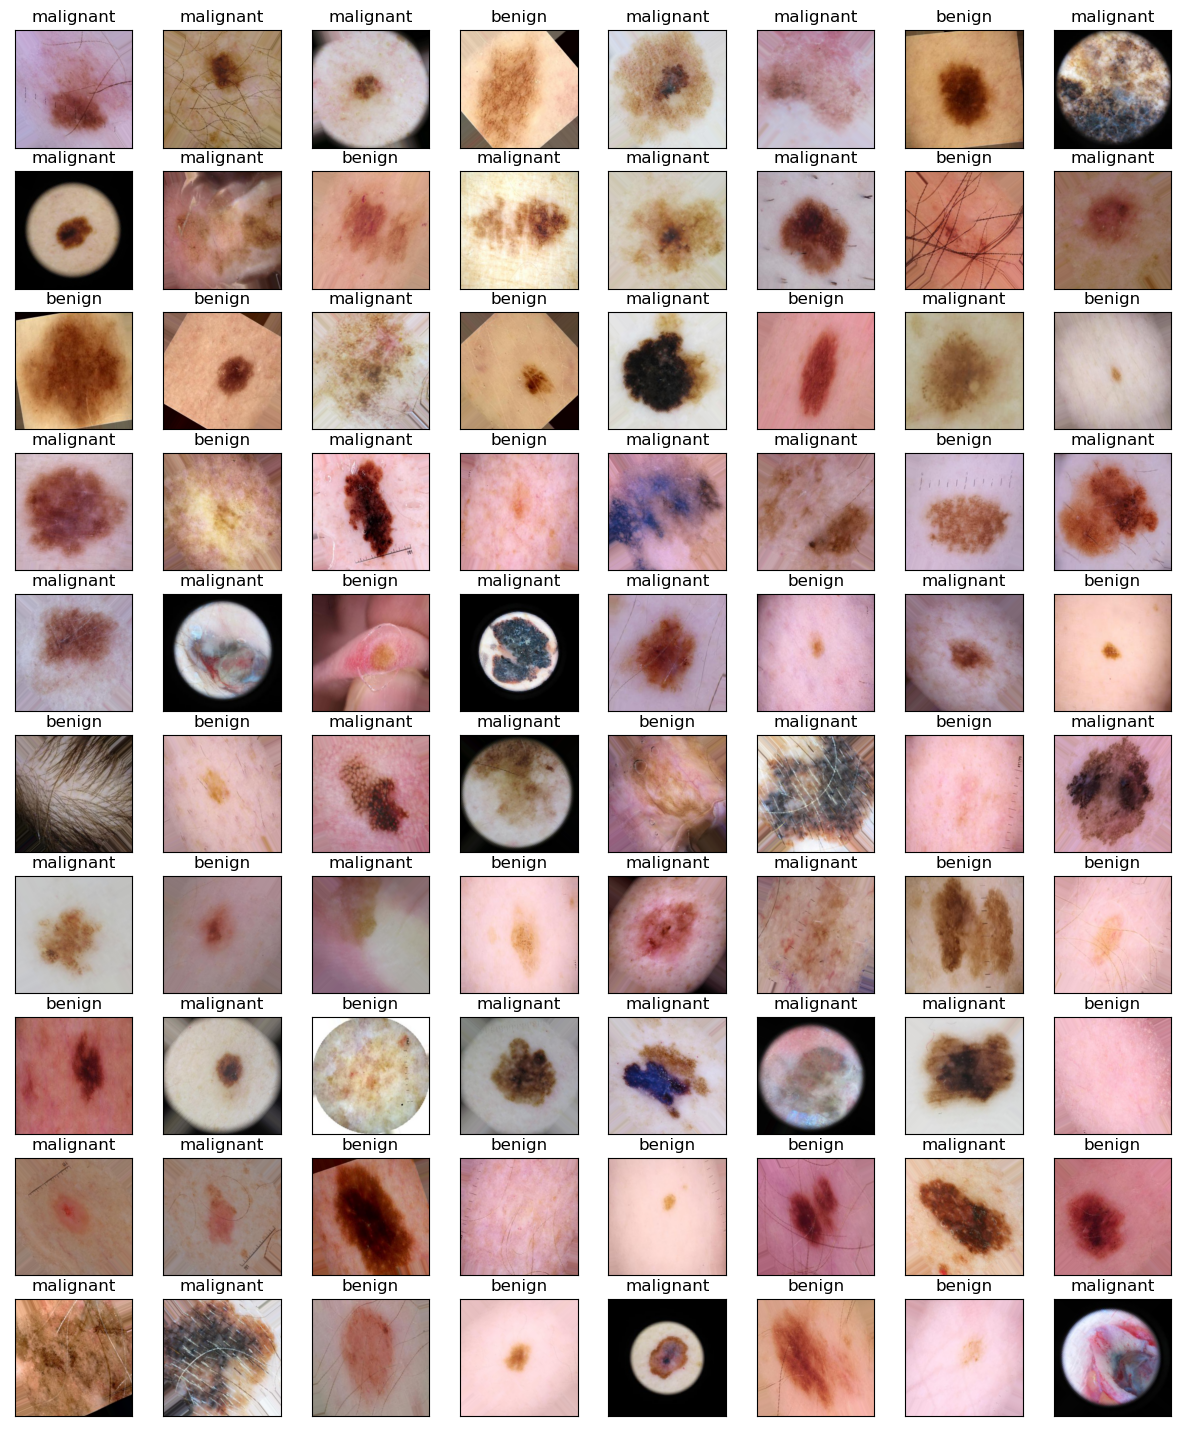

In [5]:
rows = 10
fig, axes = plt.subplots(rows,batch_size)
for r in range(rows):    
    #---get the batch of augmented images---
    image_batch = train_generator.next()    
    #---get the number of images returned---
    images_count = image_batch[0].shape[0]
    
    for c in range(images_count):
        #---convert to unsigned integers for viewing---
        image = image_batch[0][c].astype('uint8')
        
        #---display the image---
        axes[r,c].imshow(image)
        #---display the label of the image---
        axes[r,c].title.set_text(
            class_list[np.argmax(image_batch[1][c])])
        #---hides the x and y-ticks---
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])
fig.set_size_inches(15,18)

In [6]:
#---number of classes---
NO_CLASSES = max(train_generator.class_indices.values()) + 1
NO_CLASSES

2

In [7]:
#---load the VGG16 model as the base model for training---
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
#---add our own layers---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)       # add dense layers so
                                           # that the model can 
                                           # learn more complex 
                                           # functions and 
                                           # classify for better 
                                           # results.
x = Dense(1024,activation='relu')(x)       # dense layer 2
x = Dense(512,activation='relu')(x)        # dense layer 3
preds = Dense(NO_CLASSES,
              activation='softmax')(x)     # final layer with 
                                           # softmax activation

In [9]:
#---create a new model with the base model's original 
# input and the new model's output---
model = Model(inputs = base_model.input, outputs = preds)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
#---don't train the first 19 layers - 0..18---
for layer in model.layers[:19]:
    layer.trainable=False
#---train the rest of the layers - 19 onwards---
for layer in model.layers[19:]:
    layer.trainable=True

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
#---compile the model---    
model.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 9605 images belonging to 2 classes.


In [19]:
#---train the model---
step_size_train = train_generator.n // train_generator.batch_size
model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=15,
         validation_data=val_generator,
         validation_steps=len(val_generator))

Epoch 1/15
1200/1200 [==============================] - 219s 181ms/step - loss: 0.2883 - categorical_accuracy: 0.8816 - val_loss: 0.7342 - val_categorical_accuracy: 0.4794
Epoch 2/15
1200/1200 [==============================] - 207s 173ms/step - loss: 0.2704 - categorical_accuracy: 0.8911 - val_loss: 0.8225 - val_categorical_accuracy: 0.4794
Epoch 3/15
1200/1200 [==============================] - 207s 172ms/step - loss: 0.2490 - categorical_accuracy: 0.8986 - val_loss: 0.7112 - val_categorical_accuracy: 0.4794
Epoch 4/15
1200/1200 [==============================] - 206s 171ms/step - loss: 0.2494 - categorical_accuracy: 0.9014 - val_loss: 0.6959 - val_categorical_accuracy: 0.4794
Epoch 5/15
1200/1200 [==============================] - 206s 171ms/step - loss: 0.2291 - categorical_accuracy: 0.9064 - val_loss: 0.7231 - val_categorical_accuracy: 0.4794
Epoch 6/15
1200/1200 [==============================] - 204s 170ms/step - loss: 0.2312 - categorical_accuracy: 0.9087 - val_loss: 0.7510 - v

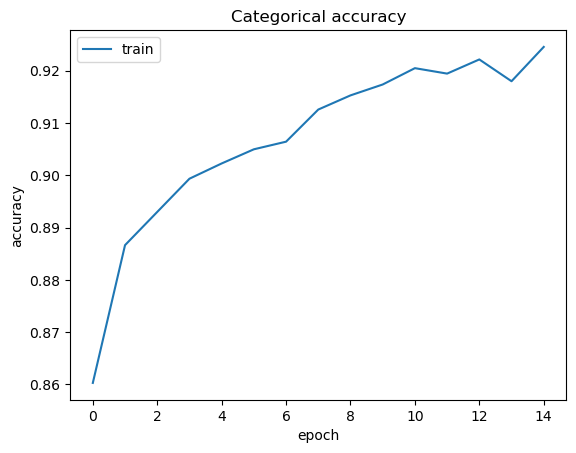

In [24]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    #plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

plot_hist(model.history)

In [21]:
print(model.history.history)

{'loss': [0.3593738079071045, 0.2782530188560486, 0.2552429437637329, 0.24321196973323822, 0.23959001898765564, 0.23015810549259186, 0.22583717107772827, 0.2204393893480301, 0.21016882359981537, 0.2082100808620453, 0.20263606309890747, 0.2060389369726181, 0.19938145577907562, 0.19926610589027405, 0.1897294521331787], 'accuracy': [0.8602688312530518, 0.8866312503814697, 0.8929873704910278, 0.8993435502052307, 0.9022611379623413, 0.9049702882766724, 0.90642911195755, 0.9125768542289734, 0.9152860045433044, 0.9173700213432312, 0.9204959869384766, 0.9194539785385132, 0.922163188457489, 0.9179952144622803, 0.9245597720146179]}
